In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [2]:
data_df = pd.read_csv('../data/processed/car_insurance_claim_processed.csv')
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,...,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,"67,349",No,0,No,M,PhD,...,Minivan,yes,"4,461",2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,"91,449",No,"257,252",No,M,High School,...,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,"52,881",No,0,No,M,Bachelors,...,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,"16,039",No,"124,191",Yes,F,High School,...,SUV,no,"38,690",2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,"306,251",Yes,M,<High School,...,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [3]:
pd.set_option('display.max_columns', None)
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,"67,349",No,0,No,M,PhD,Professional,14,Private,"14,230",11,Minivan,yes,"4,461",2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,"91,449",No,"257,252",No,M,High School,Blue Collar,22,Commercial,"14,940",1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,"52,881",No,0,No,M,Bachelors,Manager,26,Private,"21,970",1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,"16,039",No,"124,191",Yes,F,High School,Clerical,5,Private,"4,010",4,SUV,no,"38,690",2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,"306,251",Yes,M,<High School,Blue Collar,32,Private,"15,440",7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [4]:
data_df['is_claim'].value_counts(dropna=False)

is_claim
0    7555
1    2746
Name: count, dtype: int64

In [9]:
# Making sure 'new_claim_value' and 'is_claim' features are int.
data_df['new_claim_value'] = (data_df['new_claim_value'].replace(',', '', regex=True).astype(float).astype(int))
data_df['is_claim'] = data_df['is_claim'].replace(',', '', regex=True).astype(float).astype(int)

In [10]:
# Checking if there are no non-zero values for 'new_claim_value' where 'is_claim' == 1.
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

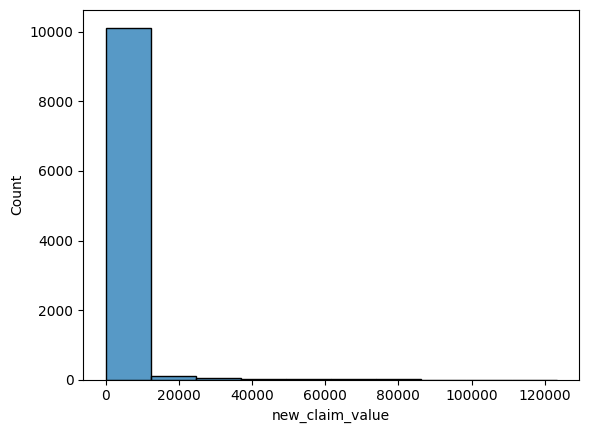

In [11]:
# Histogram for new_claim_value to see the distribution
sns.histplot(data_df['new_claim_value'], bins=10)

In [12]:
# The feature new_claim_value is severely right skewed. It's best to use non-linearly spaced bins to capture the more extreme values with few instances.
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using pd.cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<Axes: ylabel='claim_value_cat'>

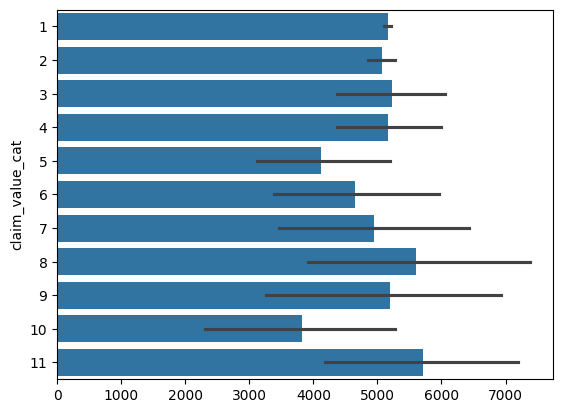

In [13]:
# We can now see the distribution of our new_claim_value categories by creating a barplot.
sns.barplot(data_df['claim_value_cat'])

In [14]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,"67,349",No,0,No,M,PhD,Professional,14,Private,"14,230",11,Minivan,yes,"4,461",2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,"91,449",No,"257,252",No,M,High School,Blue Collar,22,Commercial,"14,940",1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,"52,881",No,0,No,M,Bachelors,Manager,26,Private,"21,970",1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,"16,039",No,"124,191",Yes,F,High School,Clerical,5,Private,"4,010",4,SUV,no,"38,690",2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,NaN,No,"306,251",Yes,M,<High School,Blue Collar,32,Private,"15,440",7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1


In [16]:
data_df['claim_value_cat'].value_counts(dropna=False)

claim_value_cat
1     9316
2      789
4       48
3       45
5       27
11      19
6       18
7       14
8       10
9        8
10       7
Name: count, dtype: int64

In [18]:
# Clean of copy training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the targe feature from the X
X.drop(columns=['new_claim_value', 'is_claim'], inplace=True)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

In [19]:
# Check if the distribution of y_train and y_test class for is_claim:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


In [20]:
X_train.drop(columns=['claim_value_cat'], inplace=True)
X_test.drop(columns=['claim_value_cat'], inplace=True)

In [21]:
X_train

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type
8452,0,57.0,0,NaN,"33,707",No,0,No,F,<High School,Blue Collar,40,Private,"7,200",10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural
7822,2,41.0,3,14.0,"17,321",No,"109,835",Yes,F,<High School,Blue Collar,24,Private,"6,530",4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban
1312,0,29.0,2,12.0,"54,310",Yes,"174,139",No,M,<High School,Clerical,39,Private,"1,500",4,Minivan,no,"5,419",1,No,5,6.0,Highly Urban/ Urban
921,0,46.0,1,13.0,"62,886",Yes,"202,178",No,F,Bachelors,Professional,18,Private,"22,260",1,Minivan,no,"5,290",1,No,6,6.0,Highly Urban/ Urban
8708,0,39.0,0,8.0,"115,182",No,"312,887",Yes,M,High School,Professional,25,Commercial,"5,400",1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0,38.0,2,14.0,"54,064",No,"201,418",Yes,F,Bachelors,Professional,7,Private,"12,220",7,Sports Car,no,0,0,No,2,7.0,Highly Urban/ Urban
9650,0,38.0,0,10.0,"22,746",No,"192,479",Yes,F,Bachelors,Home Maker,5,Private,"26,300",6,Minivan,no,0,0,No,0,6.0,Highly Urban/ Urban
3204,0,48.0,0,15.0,"38,939",No,"155,006",No,M,Bachelors,Professional,28,Commercial,"31,970",4,Panel Truck,no,0,0,No,1,11.0,Highly Rural/ Rural
1427,0,29.0,2,13.0,"26,413",No,"172,043",Yes,F,High School,Clerical,29,Commercial,"16,200",4,Pickup,no,0,0,No,1,1.0,Highly Urban/ Urban


In [22]:
X_test

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type
5770,0,53.0,0,16.0,"90,526",No,"262,538",Yes,M,Bachelors,Professional,5,Commercial,"30,810",1,Panel Truck,no,0,0,No,0,NaN,Highly Rural/ Rural
8196,0,25.0,3,0.0,0,No,0,Yes,F,High School,Student,27,Commercial,"5,950",1,SUV,no,0,0,No,3,1.0,Highly Urban/ Urban
8626,0,51.0,0,9.0,"44,977",No,NaN,Yes,M,High School,Blue Collar,41,Commercial,"6,000",10,Pickup,yes,"8,060",2,No,6,1.0,Highly Urban/ Urban
6833,0,40.0,1,7.0,"34,512",Yes,0,No,M,High School,Blue Collar,51,Commercial,"8,950",6,Pickup,no,"4,955",1,No,7,1.0,Highly Urban/ Urban
9609,0,41.0,0,NaN,"78,834",No,"200,776",Yes,M,Masters,Manager,15,Commercial,"29,830",1,Panel Truck,yes,"9,980",1,No,4,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,0,46.0,0,NaN,"57,136",No,"192,619",Yes,M,High School,Professional,55,Commercial,"11,810",8,Pickup,yes,"8,446",1,No,7,8.0,Highly Urban/ Urban
4277,0,29.0,1,0.0,0,No,"66,346",Yes,F,<High School,Home Maker,34,Private,"6,170",1,SUV,no,0,0,No,0,1.0,Highly Rural/ Rural
4222,2,38.0,3,15.0,NaN,No,"339,360",Yes,F,Bachelors,Blue Collar,15,Commercial,"38,260",1,Van,no,0,0,No,2,11.0,Highly Urban/ Urban
1737,0,48.0,0,9.0,"201,768",No,0,No,F,Masters,Manager,37,Private,"31,780",7,Minivan,no,0,0,No,0,19.0,Highly Urban/ Urban


In [ ]:
# Exploratory Data Analysis
# Join X_train and y_train to investigate correlation
